## Deep Q-Network: DQN with Double Model

两个不同模型计算value和target, 缓解自举造成的过高估计

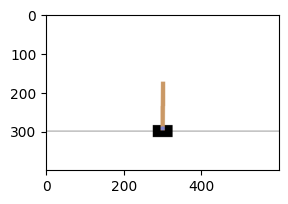

In [2]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
        over = True
    
    #没坚持到最后,扣分
    if over and self.step_n < 200:
        reward = -1000

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [3]:
import torch

#定义模型,评估状态下每个动作的价值
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

#延迟更新的模型,用于计算target
model_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

#复制参数
model_delay.load_state_dict(model.state_dict())

model, model_delay


(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
 ))

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
    if random.random() < 0.1:
      action = env.action_space.sample()

    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward

    state = next_state

    if show:
      display.clear_output(wait=True)
      env.show()

  return data, reward_sum


play()[-1]

-891.0

In [5]:
#数据池
class Pool:

  def __init__(self):
    self.pool = []

  def __len__(self):
    return len(self.pool)

  def __getitem__(self, i):
    return self.pool[i]

  #更新动作池
  def update(self):
    #每次更新不少于N条新数据
    old_len = len(self.pool)
    while len(pool) - old_len < 200:
        self.pool.extend(play()[0])

    #只保留最新的N条数据
    self.pool = self.pool[-2_0000:]

  #获取一批数据样本
  def sample(self):
    data = random.sample(self.pool, 64)

    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
    action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

    return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_40124\732246400.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(217,
 (array([0.02270371, 0.03229847, 0.0040519 , 0.01363384], dtype=float32),
  1,
  1.0,
  array([ 0.02334968,  0.22736208,  0.00432457, -0.27776793], dtype=float32),
  False))

In [6]:
#训练
def train():
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
  loss_fn = torch.nn.MSELoss()

  #共更新N轮数据
  for epoch in range(1000):
    pool.update()

    #每次更新数据后,训练N次
    for i in range(200):

      #采样N条数据
      state, action, reward, next_state, over = pool.sample()

      #计算value
      value = model(state).gather(dim=1, index=action)

      #计算target
      with torch.no_grad():
          target = model_delay(next_state)
      target = target.max(dim=1)[0].reshape(-1, 1)
      target = target * 0.99 * (1 - over) + reward

      loss = loss_fn(value, target)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #复制参数
    if (epoch + 1) % 5 == 0:
      model_delay.load_state_dict(model.state_dict())

    if epoch % 100 == 0:
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, len(pool), test_result)


train()

0 504 -984.85
100 20000 200.0
200 20000 200.0
300 20000 200.0
400 20000 200.0
500 20000 200.0
600 20000 -624.85
700 20000 200.0
800 20000 200.0
900 20000 200.0


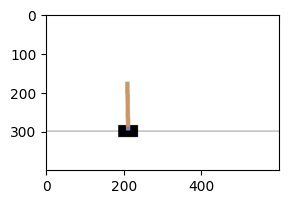

200.0

In [7]:
play(True)[-1]